## Start by importing the linear model and check the RMSLE:

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

import statsmodels.api as sm

#Load our two Data Frames
AmesDummies = pd.read_csv('AmesDummies.csv')
AmesDummiesOrdinal = pd.read_csv('AmesDummiesOrdinal.csv')

In [3]:
#Load the Forward Selection DF, which contains the list of Features to include in the linear model:
AmesFeatureDF = pd.read_csv('AmesDummiesForwardAICList.csv')

In [4]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = pd.concat([AmesDummiesOrdinal[list(AmesFeatureDF['CreatedFeatures'])],AmesDummiesOrdinal[['SalePrice']]], axis=1)
AmesDF.shape

(1458, 62)

In [5]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]
AmesDF.head()

,OverallQual,TotalSF,TotalBsmtSF,KitchenQual,BsmtExposure,SaleType_New,BsmtScore,LotArea,MasVnrArea,BedroomAbvGr,...,Neighborhood_BrDale,Neighborhood_Somerst,Neighborhood_Blmngtn,Condition_RRAe,Neighborhood_Sawyer,MasVnrType_BrkCmn,OpenPorchSF,Exterior_Plywood,MoSold_Spring,SalePrice
1,6,1262,1262,3,4,0,4.995914,9600,0.0,3,...,0,0,0,0,0,0,0,0,1,181500
2,7,1786,920,4,2,0,5.989733,11250,162.0,3,...,0,0,0,0,0,0,42,0,0,223500
3,7,1717,756,4,1,0,4.981567,9550,0.0,3,...,0,0,0,0,0,0,35,0,0,140000
4,8,2198,1145,4,3,0,5.992378,14260,350.0,4,...,0,0,0,0,0,0,84,0,0,250000
5,5,1362,796,3,1,0,5.993179,14115,0.0,1,...,0,0,0,0,0,0,30,0,0,143000


In [6]:
#Reindex the AmesDF:
AmesDF.index = range(1166)

In [8]:
#Run Linear Regression on the Overall (80%) train set, based on earlier K-fold:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Run the linear regression and check RMSLE:
lm.fit(X, Y)
lmscore = lm.score(X, Y)
lmpredict = lm.predict(X)

#Get scores for the Test set
lmtestscore = lm.score(testX, testY)
testpredict = lm.predict(testX)

RMSLE = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredict), 2)))

print("The train R^2 score is: " + str(lmscore))
print("The test R^2 score is: " + str(lmtestscore))
print("The test RMSLE is: " + str(RMSLE))


The train R^2 score is: 0.9153201995009681
The test R^2 score is: 0.8921331032914072
The test RMSLE is: 0.14310715887268688


In [9]:
#Ridge regression

from sklearn.linear_model import Ridge 
from sklearn import preprocessing

X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Standardize all input columns to 0-1
def standize_df(df,collist):
    for col in collist:
        stan_df=df[[col]]
        min_max_scaler = preprocessing.MinMaxScaler()
        standardized=min_max_scaler.fit_transform(stan_df)
        stan2_df=pd.DataFrame(standardized,columns=stan_df.columns,index=stan_df.index)
        df[[col]]=stan2_df
    return df

collist=list(X.columns)
X=standize_df(X,collist)
testX=standize_df(testX,collist)

ridge=Ridge()
ridge.set_params(alpha=5.129) #with 10 k-fold test, the best lambda =5.129
ridge.fit(X,Y)

rtrain_score=ridge.score(X,Y)
rtest_score= ridge.score(testX,testY)

testpredict = ridge.predict(testX)
RMSLE = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredict), 2)))

print ('train_score(R2)\t',rtrain_score)
print ('test_score(R2) \t',rtest_score)
print("The test RMSLE is: " + str(RMSLE))

train_score(R2)	 0.898861914958518
test_score(R2) 	 0.6263609394228908
The test RMSLE is: 0.22263355580374486


## Now, import the Random Forest model and check the overall RMSLE:

In [18]:
#Run Random Forest on the Overall (80%) train set, based on earlier K-fold:


#Import RandomForestRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, 
                        n_estimators=200)

#Run the linear regression and check RMSLE:
randomForest.fit(X, Y)
rfscore = randomForest.score(X, Y)
rfpredict = randomForest.predict(X)

#Get scores for the Test set
rftestscore = randomForest.score(testX, testY)
testpredictrf = randomForest.predict(testX)

RMSLErf = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictrf), 2)))

print("The train R^2 score is: " + str(rfscore))
print("The test R^2 score is: " + str(rftestscore))
print("The test RMSLE is: " + str(RMSLErf))

The train R^2 score is: 0.9999963846610784
The test R^2 score is: 0.9031218118988474
The test RMSLE is: 0.13646056834875153


## Now, import the Gradient Boost model and check the overall RMSLE:

In [19]:
#Run Gradient Boost on the Overall (80%) train set, based on earlier K-fold:

#Import GradientBoostRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
gradientBoost = ensemble.GradientBoostingRegressor()
gradientBoost.set_params(n_estimators=800, min_samples_split=6, min_samples_leaf=4, max_features='log2', max_depth=2, loss='huber')

#Run the linear regression and check RMSLE:
gradientBoost.fit(X, Y)
gbscore = gradientBoost.score(X, Y)
gbpredict = gradientBoost.predict(X)

#Get scores for the Test set
gbtestscore = gradientBoost.score(testX, testY)
testpredictgb = gradientBoost.predict(testX)

RMSLEgb = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictgb), 2)))

print("The train R^2 score is: " + str(gbscore))
print("The test R^2 score is: " + str(gbtestscore))
print("The test RMSLE is: " + str(RMSLEgb))

The train R^2 score is: 0.9678383681280729
The test R^2 score is: 0.9221696279270611
The test RMSLE is: 0.12560010839517527


## Combine (stack) these results to generate a prediction for SalePrice and see if it outperforms the gradient boosting prediction

In [20]:
stackedpredict = (gradientBoost.predict(testX) + randomForest.predict(testX) + lm.predict(testX))/3
RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
print("The stacked-model RMSLE is: " + str(RMSLEstacked))

The stacked-model RMSLE is: 0.11946026041666487


In [21]:
#Wow!

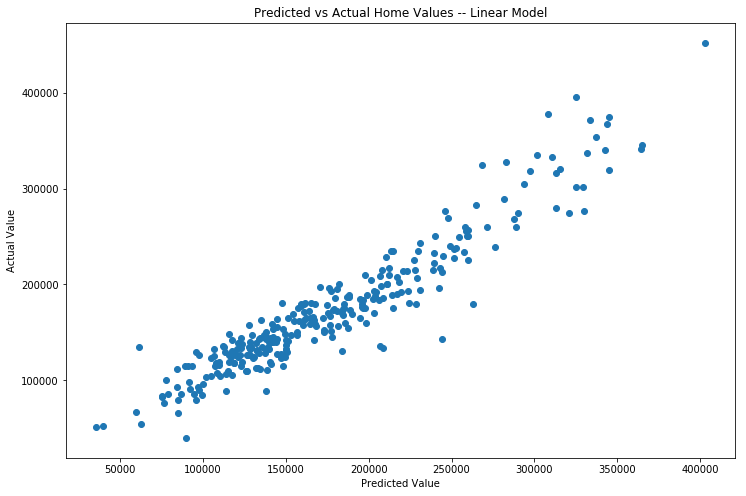

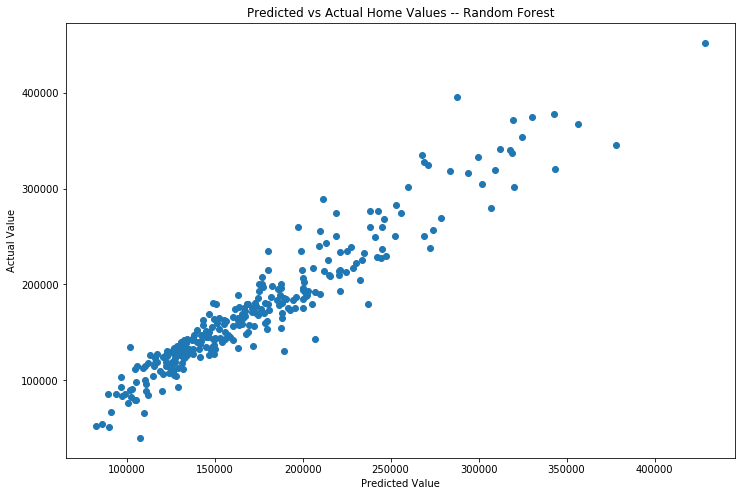

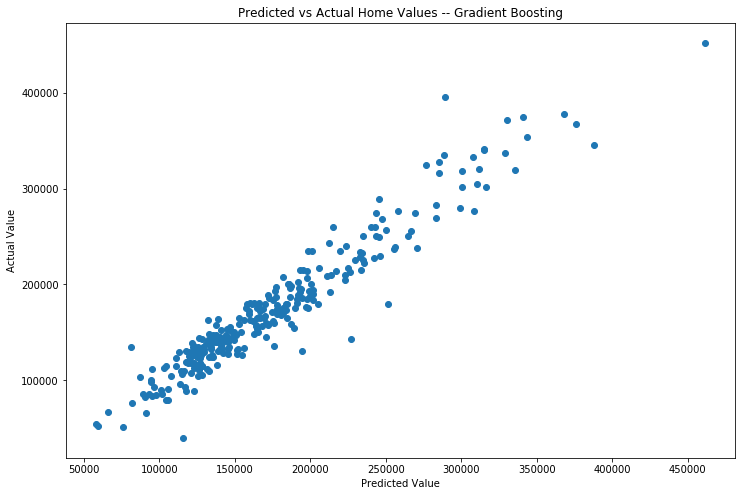

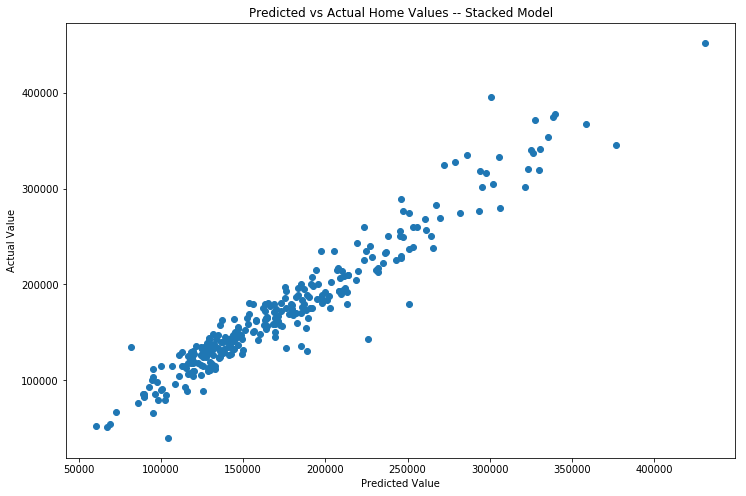

In [22]:
import matplotlib.pyplot as plt

for tup in [('Linear Model', testpredict), ('Random Forest', testpredictrf), ('Gradient Boosting', testpredictgb), ('Stacked Model', stackedpredict)]:

    plt.figure(figsize=(12,8))
    plt.scatter(tup[1], testY)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('Predicted vs Actual Home Values -- ' + tup[0])   
    plt.show()